## Welcome to Behavioral Cloning

### 1. Data Collection & Augmentation

In [1]:
import csv
import os
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from scipy import ndimage
import matplotlib.pyplot as plt
import random

#### Using a Generator

In [2]:
samples = []
with open('/home/carnd/TrainData/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
print(len(samples))

13430


In [3]:
def generator(samples, batch_size):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        #shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                current_path = '/home/carnd/TrainData/IMG/'+batch_sample[0].split('/')[-1]
                image = ndimage.imread(current_path)
                measurement = float(batch_sample[3])
                images.append(image)
                measurements.append(measurement)
            # trim image to only see section with road
            augmented_images, augmented_measurements = [],[]
            for image,measurement in zip(images,measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*-1.0)
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

In [4]:
## Data Collection and Train/Test 80/20 Split

train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(len(train_samples))
print(len(validation_samples))

batch_size = 32
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)
ch, row, col = 160, 320, 3  # Trimmed image format

10744
2686


#### Not Using a Generator

In [ ]:
##DATA COLLECTION
lines = []
with open('/home/carnd/TrainData/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
                lines.append(line)

images = []
measurements = []

for line in lines:
        source_path = line[0]
        filename = source_path.split('/')[-1]
        current_path = '/home/carnd/TrainData/IMG/' + filename
        #image = cv2.imread(current_path)
        image = ndimage.imread(current_path)
        images.append(image)
        measurement = float(line[3])
        measurements.append(measurement)

In [ ]:
##DATA AUGMENTATION
augmented_images, augmented_measurements = [],[]
for image,measurement in zip(images,measurements):
        augmented_images.append(image)
        augmented_measurements.append(measurement)
        augmented_images.append(cv2.flip(image,1))
        augmented_measurements.append(measurement*-1.0)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

### A little bit of Data Exploration

#### Not Using a Generator

In [ ]:
print(len(X_train))
indice = random.randint(0, len(X_train))
plt.figure(figsize=(1,1))
plt.imshow(X_train[indice].squeeze())
plt.show()
print(format(X_train[indice].shape))
print(y_train[indice])

#### Using a Generator

Number of augmented training data
21488
Number of augmented validation data
5372
Number of training data per epoch
64
Number of validation data per epoch
64
Train samples length and types
10744
<class 'list'>
Validation samples length and types
2686
<class 'list'>
Types for train generator, images
<class 'generator'>
<class 'list'>
<class 'numpy.ndarray'>
Shapes of full training data set then of each training image
(64, 160, 320, 3)
(160, 320, 3)
Types for validation generator, images
<class 'generator'>
<class 'list'>
<class 'numpy.ndarray'>
Shapes of full validation data set then of each validation image
(64, 160, 320, 3)
(160, 320, 3)


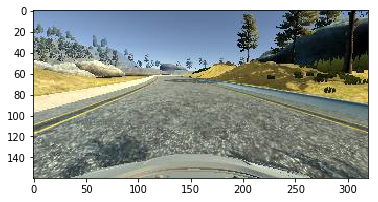

Corresponding angle
0.1856617


In [5]:
training_indice = random.randint(0, len(next(train_generator)[0]))
validation_indice = random.randint(0, len(next(validation_generator)[0]))

print("Number of augmented training data")
train_augmented = len(next(generator(train_samples, batch_size=len(samples)))[0])
print(train_augmented)
print("Number of augmented validation data")
valid_augmented = len(next(generator(validation_samples, batch_size=len(samples)))[0])
print(valid_augmented)
print("Number of training data per epoch")
print(len(next(train_generator)[0]))
print("Number of validation data per epoch")
print(len(next(validation_generator)[0]))

print("Train samples length and types")
print(len(train_samples))
print(type(train_samples))
print("Validation samples length and types")
print(len(validation_samples))
print(type(validation_samples))

print("Types for train generator, images")
print(type(train_generator))
print(type(next(train_generator)))
print(type(next(train_generator)[0]))

print("Shapes of full training data set then of each training image")
print(format(next(train_generator)[0].shape))
print(format(next(train_generator)[0][training_indice].shape))

print("Types for validation generator, images")
print(type(validation_generator))
print(type(next(validation_generator)))
print(type(next(validation_generator)[0]))

print("Shapes of full validation data set then of each validation image")
print(format(next(validation_generator)[0].shape))
print(format(next(validation_generator)[0][validation_indice].shape))


plt.imshow((next(train_generator)[0][training_indice]))
plt.show()
print("Corresponding angle")
print((next(train_generator)[1][training_indice]))

### 2. Model Definition and Training

In [6]:
##IMPORT LIBRARIES
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D

Using TensorFlow backend.


#### Not Using Generator

In [ ]:
##PREPROCESSING
ch, row, col = 160, 320, 3  # Trimmed image format
model  = Sequential()
model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(ch,row,col)))
model.add(Cropping2D(cropping=((70,25),(0,0))))

#### Using Generator

In [7]:
###GENERATOR TECHNIQUE PREPROCESSING
model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(ch, row, col),output_shape=(ch, row, col)))
model.add(Cropping2D(cropping=((70,25),(0,0))))

#### LeNet Model

In [ ]:
#LENET

model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

#### Nvidia Team Model

In [8]:
##NVIDIA

model.add(Convolution2D(24,5,5,subsample=(2,2),activation="elu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="elu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="elu"))
model.add(Convolution2D(64,3,3,activation="elu"))
model.add(Convolution2D(64,3,3,activation="elu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

#### Fitting Without Generator

In [ ]:
model.compile(loss='mse', optimizer ='adam')
model.fit(X_train,y_train, validation_split = 0.2, shuffle = True,nb_epoch=5)
model.save('model2.h5')

#### Fitting With Generator

In [9]:
from keras import optimizers

adam = optimizers.Adam(lr=0.00009)
model.compile(loss='mse', optimizer=adam)
history_object = model.fit_generator(train_generator, samples_per_epoch= train_augmented, 
                                     validation_data=validation_generator, 
                                     nb_val_samples=valid_augmented, 
                                     nb_epoch=6, 
                                     verbose=1)

model.save('model_generator.h5')

Epoch 1/6
21488/21488 [==============================] - 42s - loss: 0.0114 - val_loss: 0.0067
Epoch 2/6
21488/21488 [==============================] - 39s - loss: 0.0061 - val_loss: 0.0056
Epoch 3/6
21488/21488 [==============================] - 38s - loss: 0.0051 - val_loss: 0.0050
Epoch 4/6
21488/21488 [==============================] - 39s - loss: 0.0046 - val_loss: 0.0046
Epoch 5/6
21488/21488 [==============================] - 39s - loss: 0.0043 - val_loss: 0.0044
Epoch 6/6
21488/21488 [==============================] - 39s - loss: 0.0041 - val_loss: 0.0043


dict_keys(['loss', 'val_loss'])


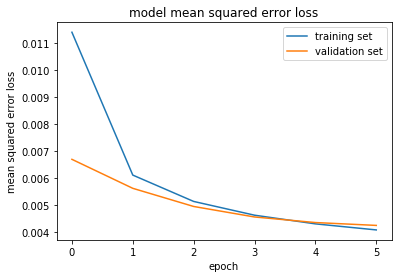

In [10]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()